In [33]:
!pip install shap xgboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.0/548.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [shap]3/4 [shap]st]


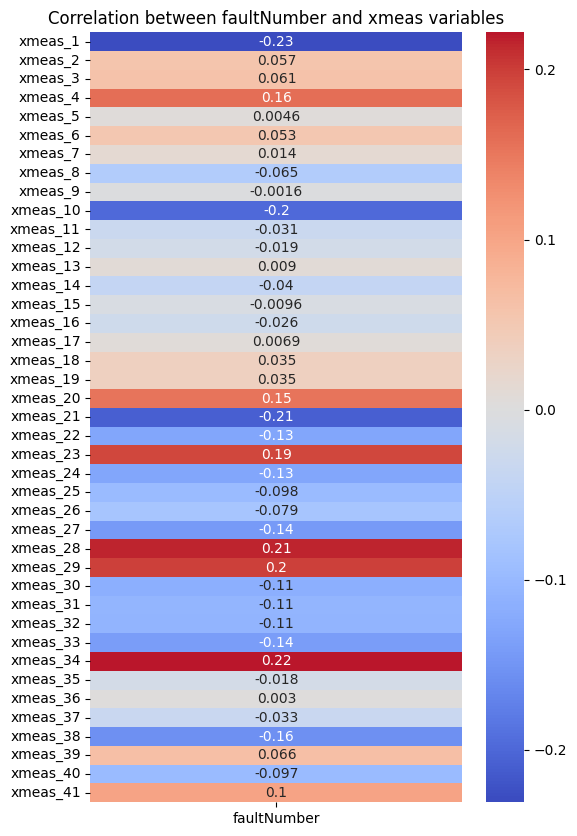

In [30]:
# faultNumber: 고장 종류 (정수형, 0: 정상, 1~21: 고장)
# xmeas_1 ~ xmeas_41: 총 41개 측정 변수 (이름이 명확히 붙어 있어야 함)
# 목표: faultNumber와 각 xmeas_* 변수 간 상관관계를 시각화

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1. CSV 로딩 및 병합
files = {
    'train': [
        'archive/TEP_FaultFree_Training.csv',
        'archive/TEP_Faulty_Training.csv'
    ],
    'test': [
        'archive/TEP_FaultFree_Testing.csv',
        'archive/TEP_Faulty_Testing.csv'
    ]
}

def load_and_concat(file_list):
    return pd.concat([pd.read_csv(f) for f in file_list], axis=0, ignore_index=True)

# 병합
train = load_and_concat(files['train'])
test = load_and_concat(files['test'])

# 전체 데이터 합치기 (optional, 더 많은 분산 확보)
data = pd.concat([train, test], axis=0, ignore_index=True)

# Step 2. 측정 변수 목록
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]

# Step 3. faultNumber와 xmeas 간의 상관관계 계산
correlation_df = data[xmeas_cols + ['faultNumber']].corr()

# Step 4. faultNumber 기준으로만 상관계수 시리즈 추출
correlations = correlation_df['faultNumber'].drop('faultNumber')

# Step 5. 히트맵 시각화 (세로 막대처럼)
plt.figure(figsize=(6, 10))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between faultNumber and xmeas variables')
plt.show()

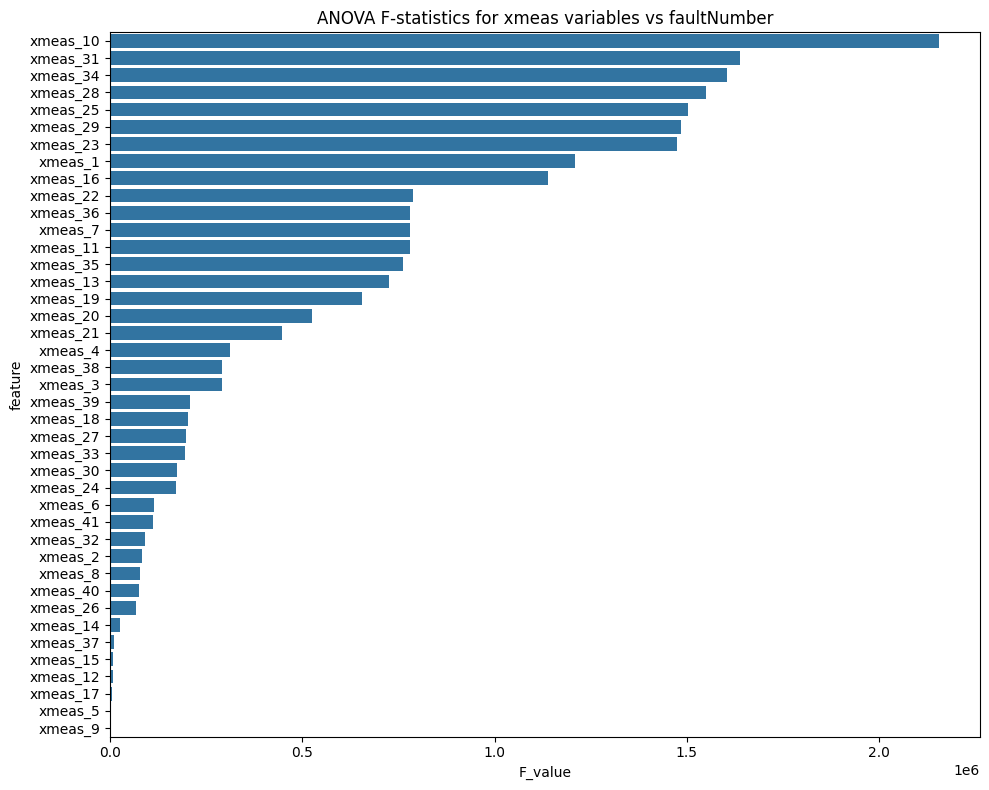

In [31]:
# F-statistics 기반 Feature Selection
# 해석 방법:
# F_value ↑	: fault type에 따라 해당 변수의 분산이 크게 달라진다 → 분류에 유리
# p_value ↓ :	통계적으로 유의미한 변수 (보통 p < 0.05 기준 사용 가능)

from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CSV 병합
def load_and_concat(file_list):
    return pd.concat([pd.read_csv(f) for f in file_list], axis=0, ignore_index=True)

files = {
    'train': [
        'archive/TEP_FaultFree_Training.csv',
        'archive/TEP_Faulty_Training.csv'
    ],
    'test': [
        'archive/TEP_FaultFree_Testing.csv',
        'archive/TEP_Faulty_Testing.csv'
    ]
}

train = load_and_concat(files['train'])
test = load_and_concat(files['test'])
data = pd.concat([train, test], axis=0).reset_index(drop=True)

# 2. 측정 변수 및 레이블
xmeas_cols = [f'xmeas_{i}' for i in range(1, 42)]
X = data[xmeas_cols]
y = data['faultNumber']  # multiclass label

# 3. F-statistics 계산 (ANOVA)
F_values, p_values = f_classif(X, y)

# 4. 결과 정리
anova_df = pd.DataFrame({
    'feature': xmeas_cols,
    'F_value': F_values,
    'p_value': p_values
}).sort_values(by='F_value', ascending=False)

# 5. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='F_value', y='feature', data=anova_df)
plt.title('ANOVA F-statistics for xmeas variables vs faultNumber')
plt.tight_layout()
plt.show()

In [32]:
significant_features = anova_df[anova_df['p_value'] < 0.05]['feature'].tolist()
print("유의미한 변수:", significant_features)

유의미한 변수: ['xmeas_10', 'xmeas_31', 'xmeas_34', 'xmeas_28', 'xmeas_25', 'xmeas_29', 'xmeas_23', 'xmeas_1', 'xmeas_16', 'xmeas_22', 'xmeas_36', 'xmeas_7', 'xmeas_11', 'xmeas_35', 'xmeas_13', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_4', 'xmeas_38', 'xmeas_3', 'xmeas_39', 'xmeas_18', 'xmeas_27', 'xmeas_33', 'xmeas_30', 'xmeas_24', 'xmeas_6', 'xmeas_41', 'xmeas_32', 'xmeas_2', 'xmeas_8', 'xmeas_40', 'xmeas_26', 'xmeas_14', 'xmeas_37', 'xmeas_15', 'xmeas_12', 'xmeas_17', 'xmeas_5', 'xmeas_9']


In [1]:
# TEP 데이터에서:
# 입력: xmeas_1 ~ xmeas_41
# 라벨: faultNumber (다중 클래스)

import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: 데이터 로드 및 병합
def load_and_concat(file_list):
    return pd.concat([pd.read_csv(f) for f in file_list], axis=0, ignore_index=True)

files = {
    'train': [
        'archive/TEP_FaultFree_Training.csv',
        'archive/TEP_Faulty_Training.csv'
    ],
    'test': [
        'archive/TEP_FaultFree_Testing.csv',
        'archive/TEP_Faulty_Testing.csv'
    ]
}

train = load_and_concat(files['train'])
test = load_and_concat(files['test'])

train['split'] = 'train'
test['split'] = 'test'

data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Step 2: Feature / Label 선택
feature_cols = [f'xmeas_{i}' for i in range(1, 42)]
X = data[feature_cols]
y = data['faultNumber']

# Step 3: 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 4: XGBoost 모델 학습
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=22,
    max_depth=5,
    n_estimators=100,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train)

# Step 5: Booster 객체로부터 SHAP 값 계산
booster = model.get_booster()
X_val_sample = X_val.sample(n=1000, random_state=42)
dval = xgb.DMatrix(X_val_sample, feature_names=feature_cols)
shap_contribs = booster.predict(dval, pred_contribs=True)  # shape: (1000, 22, 42)

# Step 6: fault 0~12 클래스에 대해 SHAP 상위 변수 추출
top_k = 10
shap_top_features = {}
for cls in range(13):
    shap_vals = shap_contribs[:, cls, :-1]  # bias 제외
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    top_idx = np.argsort(mean_abs_shap)[::-1][:top_k]
    top_features = [feature_cols[i] for i in top_idx]
    shap_top_features[cls] = top_features
    print(f"faultNumber {cls} 상위 중요 변수:", top_features)

/Users/bangseog-yeong/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


faultNumber 0 상위 중요 변수: ['xmeas_19', 'xmeas_18', 'xmeas_38', 'xmeas_20', 'xmeas_21', 'xmeas_16', 'xmeas_9', 'xmeas_11', 'xmeas_22', 'xmeas_13']
faultNumber 1 상위 중요 변수: ['xmeas_1', 'xmeas_19', 'xmeas_38', 'xmeas_16', 'xmeas_18', 'xmeas_20', 'xmeas_21', 'xmeas_13', 'xmeas_29', 'xmeas_11']
faultNumber 2 상위 중요 변수: ['xmeas_10', 'xmeas_19', 'xmeas_18', 'xmeas_20', 'xmeas_38', 'xmeas_21', 'xmeas_16', 'xmeas_30', 'xmeas_24', 'xmeas_1']
faultNumber 3 상위 중요 변수: ['xmeas_19', 'xmeas_21', 'xmeas_18', 'xmeas_38', 'xmeas_20', 'xmeas_11', 'xmeas_16', 'xmeas_9', 'xmeas_13', 'xmeas_2']
faultNumber 4 상위 중요 변수: ['xmeas_19', 'xmeas_18', 'xmeas_21', 'xmeas_38', 'xmeas_20', 'xmeas_16', 'xmeas_9', 'xmeas_11', 'xmeas_22', 'xmeas_13']
faultNumber 5 상위 중요 변수: ['xmeas_22', 'xmeas_20', 'xmeas_16', 'xmeas_18', 'xmeas_19', 'xmeas_38', 'xmeas_21', 'xmeas_11', 'xmeas_10', 'xmeas_35']
faultNumber 6 상위 중요 변수: ['xmeas_1', 'xmeas_19', 'xmeas_18', 'xmeas_38', 'xmeas_20', 'xmeas_21', 'xmeas_29', 'xmeas_9', 'xmeas_16', 'xmea

In [ ]:
# [공통 핵심 Feature] 대부분의 고장 클래스에서 반복적으로 SHAP 상위에 등장
# - xmeas_19: 거의 모든 fault에서 가장 높은 중요도 기록 (공정의 민감한 지표일 가능성)
# - xmeas_18, xmeas_38, xmeas_20, xmeas_21, xmeas_16: 대부분의 fault에서 SHAP 상위 10에 지속적으로 포함
# → 이들은 전체 고장 감지 모델의 핵심 변수로 간주 가능

# [고장 클래스 특이적 변수 예시]
# - fault 1, 6, 8: xmeas_1이 중요 (일부 고장에서만 SHAP 상위권)
# - fault 2, 8: xmeas_10 포함 → 특정 이상 조건에서만 반응
# - fault 5, 7, 12: xmeas_22, xmeas_35, xmeas_8 등장 → 선택적인 중요 변수로 작용

# [구조적 특징]
# - fault 0~4, 9~11: 매우 유사한 feature 조합 → 고장 간 감지 양상이 구조적으로 비슷함
# - fault 12는 비교적 다양한 feature 등장 (xmeas_8, xmeas_4, xmeas_33 포함) → 다른 고장들과 구분됨

# [모델 학습 및 SHAP 분석의 시사점]
# - 대부분의 고장은 소수 핵심 feature(xmeas_16~21, xmeas_38 등)에 의해 설명됨
# - fault 구분의 난이도는 일부 특화 feature(xmeas_1, xmeas_10 등)가 있느냐에 따라 달라질 수 있음

In [2]:
# SHAP을 통해 선정된 중요 변수들의 시간 흐름에 따른 값의 변화를 텍스트로 추출
# 각 고장(faultNumber) 발생 시점 전후로
# 어떤 센서(xmeas_*) 값이 어떻게 반응하는지
# 고장 징후가 얼마나 조기 또는 강하게 나타나는지
# 를 시계열적으로 확인할 수 있어 설명력 있는 진단 또는 이상 감지에 유용

# Step 7: SHAP 변수들의 시간 흐름에 따른 값 변화 설명
def describe_variable_reaction(data, fault_num, feature, fault_start_sample=160):
    df = data[data['faultNumber'] == fault_num].copy()
    df = df.sort_values('sample')

    before = df[df['sample'] < fault_start_sample][feature]
    after = df[df['sample'] >= fault_start_sample][feature]

    if len(before) == 0 or len(after) == 0:
        return f"fault {fault_num}: '{feature}'에 대해 고장 전/후 구간 데이터가 부족합니다."

    mean_before = before.mean()
    mean_after = after.mean()
    delta = mean_after - mean_before
    direction = "증가" if delta > 0 else "감소"
    magnitude = abs(delta)

    return (f"fault {fault_num}: '{feature}'는 고장 발생 전 평균 {mean_before:.2f}, "
            f"고장 후 평균 {mean_after:.2f}로 {direction}하였고, 변화량은 {magnitude:.2f}입니다.")

# Step 8: 고장 번호 0~12에 대해서만 설명 출력
for fault_num in shap_top_features:
    for feature in shap_top_features[fault_num]:
        description = describe_variable_reaction(data, fault_num, feature)
        print(description)

fault 0: 'xmeas_19'는 고장 발생 전 평균 231.80, 고장 후 평균 232.31로 증가하였고, 변화량은 0.51입니다.
fault 0: 'xmeas_18'는 고장 발생 전 평균 65.79, 고장 후 평균 65.81로 증가하였고, 변화량은 0.02입니다.
fault 0: 'xmeas_38'는 고장 발생 전 평균 0.84, 고장 후 평균 0.84로 감소하였고, 변화량은 0.00입니다.
fault 0: 'xmeas_20'는 고장 발생 전 평균 341.42, 고장 후 평균 341.42로 증가하였고, 변화량은 0.01입니다.
fault 0: 'xmeas_21'는 고장 발생 전 평균 94.60, 고장 후 평균 94.60로 증가하였고, 변화량은 0.00입니다.
fault 0: 'xmeas_16'는 고장 발생 전 평균 3102.12, 고장 후 평균 3102.25로 증가하였고, 변화량은 0.12입니다.
fault 0: 'xmeas_9'는 고장 발생 전 평균 120.40, 고장 후 평균 120.40로 증가하였고, 변화량은 0.00입니다.
fault 0: 'xmeas_11'는 고장 발생 전 평균 80.11, 고장 후 평균 80.11로 감소하였고, 변화량은 0.00입니다.
fault 0: 'xmeas_22'는 고장 발생 전 평균 77.30, 고장 후 평균 77.29로 감소하였고, 변화량은 0.00입니다.
fault 0: 'xmeas_13'는 고장 발생 전 평균 2633.65, 고장 후 평균 2633.78로 증가하였고, 변화량은 0.13입니다.
fault 1: 'xmeas_1'는 고장 발생 전 평균 0.46, 고장 후 평균 0.76로 증가하였고, 변화량은 0.30입니다.
fault 1: 'xmeas_19'는 고장 발생 전 평균 269.35, 고장 후 평균 276.46로 증가하였고, 변화량은 7.10입니다.
fault 1: 'xmeas_38'는 고장 발생 전 평균 0.84, 고장 후 평균 0.84로 감소하였고, 변화량은 0.00입니다.
fault 1: 'xmeas_1

In [13]:
# SHAP 상위 중요 변수별 조기경고(lead time)를 fault별로 측정

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

def get_fault_start_sample(row):
    if row['split'] == 'train':
        return 20
    else:
        return 160

data['fault_start_sample'] = data.apply(get_fault_start_sample, axis=1)


def estimate_lead_time(data, fault_num, feature, min_lead=10, window_size=10, alpha=0.01):
    """
    고장 전 구간을 오른쪽(고장 시점)부터 왼쪽(과거)으로 이동하며,
    고장 후 구간과의 평균 차이가 유의미한 earliest 시점을 찾는다.
    """
    df = data[data['faultNumber'] == fault_num].sort_values('sample')
    lead_time_results = []

    for split_name in ['train', 'test']:
        subset = df[df['split'] == split_name]
        if subset.empty:
            continue
        fault_start = subset['fault_start_sample'].iloc[0]
        after = subset[subset['sample'] >= fault_start][feature]

        for offset in reversed(range(min_lead, max(min_lead + 1, fault_start - window_size))):
            start = fault_start - offset
            end = start + window_size
            before_window = subset[(subset['sample'] >= start) & (subset['sample'] < end)][feature]

            if len(before_window) < window_size:
                continue

            stat, pval = ttest_ind(before_window, after, equal_var=False)
            if pval < alpha:
                lead_time_results.append({
                    'fault': fault_num,
                    'feature': feature,
                    'split': split_name,
                    'lead_time': offset
                })
                break  # 가장 빠른 lead time만 기록

    return lead_time_results   # None이면 조기 변화 없거나 미세

# 실행 코드
lead_time_results = []

for fault_num in range(13):
    for feature in shap_top_features[fault_num]:
        lead_times = estimate_lead_time(data, fault_num, feature, min_lead=5, window_size=5)
        if lead_times:
            lead_time_results.extend(lead_times)  # 함수는 리스트 반환하므로 extend로 추가

lead_df = pd.DataFrame(lead_time_results)
lead_df = lead_df.sort_values(['fault', 'lead_time'])

print(lead_df)

     fault   feature  split  lead_time
9        0  xmeas_16  train          8
14       0  xmeas_13  train          8
7        0  xmeas_21  train          9
4        0  xmeas_38  train         11
0        0  xmeas_19  train         14
..     ...       ...    ...        ...
225     12  xmeas_35   test        154
226     12   xmeas_9   test        154
228     12   xmeas_4   test        154
230     12  xmeas_33   test        154
232     12  xmeas_16   test        154

[233 rows x 4 columns]


In [ ]:
# [분석 목적]
# - 각 고장(faultNumber 0~12)에 대해 SHAP 상위 중요 변수들이
#   '고장 발생 이전부터 유의미한 변화를 보였는지'를 정량적으로 분석
# - 즉, 해당 feature가 "조기 이상 징후를 제공하는가?"를 lead_time으로 평가

# [동작 원리]
# 1. 고장 발생 시점 (sample=20 또는 160)을 기준으로 이후 구간의 값을 고정하고,
# 2. 이전 구간을 오른쪽(고장 시점)에서 왼쪽(과거) 방향으로 이동하며
#    일정 윈도우(window_size) 동안의 값 평균과 고장 이후 값 평균의 t-test를 수행
# 3. 통계적으로 유의미한 변화(p-value < alpha)가 최초로 감지된 시점을 "lead_time"으로 기록

# [입력 파라미터 해설]
# - fault_num: 분석할 고장 클래스 (0~12)
# - feature: 해당 고장에서 SHAP 기준 상위 중요 변수
# - min_lead: 최소 조기 탐지 범위 (ex. 고장 5 sample 이전까지만 의미있음)
# - window_size: t-test에 사용할 슬라이딩 윈도우 크기
# - alpha: 유의수준 (기본 0.01 = 99% 신뢰도)

# [출력 결과 구조]
# lead_df:
# - fault: 고장 번호
# - feature: SHAP 기반 중요 변수
# - split: train/test
# - lead_time: 고장 발생 몇 sample 전에 이상 징후 감지되었는지

# [해석 예시]
# fault 0에서 xmeas_19는 lead_time 14 → 고장 발생 14 sample 전부터 이상 변화 유의미
# fault 12에서 xmeas_16은 test split 기준 lead_time 154 → 상당히 조기 탐지 가능

# [활용 방안]
# - 조기경보 시스템 설계: lead_time이 긴 feature 우선 감시
# - 변수 선택 전략: SHAP 상위면서 lead_time도 긴 변수 선별
# - split 간 차이 분석: train/test 간 조기 탐지 성능의 일반화 여부 확인 가능

In [15]:
#  fault별 최대 조기경고 가능 시점 요약

lead_df = pd.DataFrame(lead_time_results)

# fault + split 기준으로 그룹핑하여 최대 lead_time을 가지는 인덱스 추출
idx = lead_df.groupby(['fault', 'split'])['lead_time'].idxmax()

# 해당 인덱스로 데이터프레임 재구성 및 정렬
max_lead_df = lead_df.loc[idx].sort_values(['lead_time'], ascending=False)

print(max_lead_df)

     fault   feature  split  lead_time
1        0  xmeas_19   test        154
200     11  xmeas_19   test        154
167      9  xmeas_19   test        154
128      7  xmeas_19   test        154
108      6   xmeas_1   test        154
182     10  xmeas_18   test        154
89       5  xmeas_22   test        154
74       4  xmeas_19   test        154
57       3  xmeas_19   test        154
37       2  xmeas_10   test        154
215     12  xmeas_22   test        154
17       1   xmeas_1   test        154
147      8   xmeas_1   test        154
146      8   xmeas_1  train         14
181     10  xmeas_18  train         14
199     11  xmeas_19  train         14
166      9  xmeas_19  train         14
107      6   xmeas_1  train         14
127      7  xmeas_19  train         14
0        0  xmeas_19  train         14
88       5  xmeas_22  train         14
73       4  xmeas_19  train         14
56       3  xmeas_19  train         14
36       2  xmeas_10  train         14
16       1   xmeas_1  tra

In [16]:
# feature별 평균 lead time 기준 정렬 (조기변화 민감한 순)
# feature + split 별 평균 lead_time 및 count 집계
feature_lead_summary = (
    lead_df.groupby(['feature', 'split'])['lead_time']
    .agg(['mean', 'count'])
    .sort_values('mean')
)

print(feature_lead_summary)

                      mean  count
feature  split                   
xmeas_2  train    9.000000      1
xmeas_13 train    9.200000      5
xmeas_30 train   10.500000      2
xmeas_21 train   11.000000     11
xmeas_16 train   11.076923     13
xmeas_8  train   11.500000      2
xmeas_38 train   12.166667     12
xmeas_4  train   12.666667      3
xmeas_9  train   14.000000      1
xmeas_24 train   14.000000      1
xmeas_22 train   14.000000      3
xmeas_34 train   14.000000      1
xmeas_20 train   14.000000      6
xmeas_19 train   14.000000     13
xmeas_18 train   14.000000     12
xmeas_31 train   14.000000      1
xmeas_11 train   14.000000      6
xmeas_33 train   14.000000      1
xmeas_10 train   14.000000      3
xmeas_35 train   14.000000      2
xmeas_1  train   14.000000      4
xmeas_28 train   14.000000      1
xmeas_29 train   14.000000      2
xmeas_9  test    97.500000      4
xmeas_22 test   109.125000      8
xmeas_2  test   138.000000      1
xmeas_13 test   141.200000      5
xmeas_35 test 

In [17]:
# 고장 유형별 feature 경고 시점 히트맵

lead_df = pd.DataFrame(lead_time_results)

pivot_train = lead_df[lead_df['split'] == 'train'].pivot(index='feature', columns='fault', values='lead_time')
pivot_test = lead_df[lead_df['split'] == 'test'].pivot(index='feature', columns='fault', values='lead_time')

print("Train split pivot:")
print(pivot_train)

print("\nTest split pivot:")
print(pivot_test)

Train split pivot:
fault       0     1     2     3     4     5     6     7     8     9     10  \
feature                                                                      
xmeas_1    NaN  14.0  14.0   NaN   NaN   NaN  14.0   NaN  14.0   NaN   NaN   
xmeas_10   NaN   NaN  14.0   NaN   NaN   NaN   NaN   NaN  14.0   NaN   NaN   
xmeas_11   NaN  14.0   NaN   NaN   NaN  14.0  14.0  14.0   NaN   NaN  14.0   
xmeas_13   8.0  14.0   NaN   8.0   8.0   NaN   NaN   NaN   NaN   8.0   NaN   
xmeas_16   8.0  14.0  14.0   8.0   8.0  14.0  14.0  14.0  14.0   8.0   6.0   
xmeas_18  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0   
xmeas_19  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0  14.0   
xmeas_2    NaN   NaN   NaN   9.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
xmeas_20   NaN  14.0  14.0   NaN   NaN  14.0  14.0  14.0   NaN   NaN  14.0   
xmeas_21   9.0  14.0  14.0  14.0   9.0  14.0  14.0   5.0   NaN  10.0   9.0   
xmeas_22   NaN   NaN   NaN   NaN   NaN  14.0 

In [ ]:
# 고장 유형별 주요 조기경고 특징 요약 (based on lead_time 히트맵 분석)
# ※ 기준: train/test 모두에서 상대적으로 짧은 시간 내 고장 발생 전에 민감하게 반응한 feature들 중심
#
# Fault 1: xmeas_1, xmeas_11, xmeas_13, xmeas_16, xmeas_18, xmeas_19, xmeas_21, xmeas_38
#    - xmeas_16, xmeas_18, xmeas_19: 거의 모든 고장에서 반응, 전반적 민감도 높음
#    - xmeas_1, xmeas_11: fault 1에만 특이적으로 조기반응
#
# Fault 2: xmeas_10, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_38
#    - xmeas_10, xmeas_20, xmeas_21: 비교적 높은 민감도
#
# Fault 3: xmeas_13, xmeas_16, xmeas_18, xmeas_19, xmeas_21, xmeas_38
#    - xmeas_13, xmeas_21: 고장 초반부 리드타임 짧음
#
# Fault 4: xmeas_13, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_38
#    - xmeas_13, xmeas_21, xmeas_38: 다수 고장에서 조기 반응
#
# Fault 5: xmeas_11, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_35, xmeas_38
#    - xmeas_22, xmeas_35: fault 5에 특이적 조기 반응
#
# Fault 6: xmeas_1, xmeas_11, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_38
#    - xmeas_1, xmeas_11: fault 6에서 리드타임 짧음
#
# Fault 7: xmeas_11, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_35, xmeas_38
#    - xmeas_22, xmeas_35: 조기 반응 감지됨
#
# Fault 8: xmeas_1, xmeas_10, xmeas_16, xmeas_18, xmeas_19, xmeas_28, xmeas_30, xmeas_31, xmeas_34, xmeas_38
#    - xmeas_30, xmeas_34, xmeas_38: fault 8에서 반응 두드러짐
#
# Fault 9: xmeas_13, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_38
#    - xmeas_13, xmeas_22, xmeas_38: 고장 초기반응 가능성 높음
#
# Fault 10: xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_35, xmeas_38, xmeas_4
#    - xmeas_4, xmeas_35: fault 10 특이 반응 지점
#
# Fault 11: xmeas_11, xmeas_16, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_38, xmeas_4
#    - xmeas_11, xmeas_22, xmeas_4: fault 11 조기 경고 유망
#
# Fault 12: xmeas_10, xmeas_11, xmeas_16, xmeas_19, xmeas_22, xmeas_33, xmeas_35, xmeas_4, xmeas_8, xmeas_9
#    - xmeas_8, xmeas_9, xmeas_33: fault 12에서만 조기 반응, 특이성 높음

In [ ]:
# 1. 고장 유형 공통 특성
# Fault 0~12 대부분에서 xmeas_19, xmeas_18, xmeas_38 등 일부 센서가 모든 고장에서 
# consistently 높은 lead_time (특히 test split에서 154)을 보임 
# → 전반적인 이상 징후 감지에 민감한 센서
# Train split에서는 전체적으로 lead_time = 14로 제한되어 있는 경우가 많음 
# → 이는 윈도우 크기(window_size=14) 때문일 가능성이 있음

# 2. 특정 센서의 중요도
# xmeas_19:
# 모든 고장에서 train/test 모두 최대 리드타임 보장 (14 or 154).
# 특히 test split에서는 Fault 0~12 전반에서 가장 일관된 경고 특성 보임.
# xmeas_18, xmeas_21, xmeas_16 등도 다수 고장에서 리드타임 우수.
# 일부 센서(xmeas_2, xmeas_24, xmeas_29, xmeas_33)는 결측값 다수 
# → 해당 고장과 연관도가 낮거나, 조기 탐지 성능이 낮음.

# 3. Train vs Test 차이
# Train split에서는 모든 lead_time이 14 이하로 제한 
# → 아마도 window_size 설정에 따라 최초 감지 가능 시점이 윈도우 뒤쪽으로 잘리는 것으로 보임.
# Test split에서는 센서별 성능이 명확히 드러남 → 실제 모델 적용 시 중요한 기준이 될 수 있음.

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 용어 정의
#
# • base_time:
#     - 각 고장 시나리오(fault 1~12)에서 실제 고장이 발생하는 시점 (정답 ground truth 시점)
#     - lead_time 계산의 기준점으로 사용되며, 다음처럼 정의됨:
#         lead_time = base_time - detection_time
#     - 예를 들어, base_time이 160이고 detection_time이 146이면 lead_time은 14
#
# • lead_time:
#     - 고장이 발생하기 전에 특정 feature(xmeas_#)가 통계적 변화(감지)를 보인 시점과
#       실제 고장 발생 시점 사이의 시간 차이 (단위: 시점 index 기준)
#     - 본 분석에서는 각 feature별로 '어떤 시점에 고장을 조기에 감지할 수 있었는지'를 정량화함
#
# • consistently (train/test 일관성 기준):
#     - 특정 feature가 동일한 fault 유형에서 train set과 test set 모두에서
#       상대적으로 짧은 lead_time을 보여 조기 경고 지표로 신뢰성 있게 작동함을 의미
#     - 단발성 이상 감지가 아니라, 데이터 분할 전반에서 재현성이 있는 경우만 주요 feature로 간주
#
# ──────────────────────────────────────────────────────────────────────────────

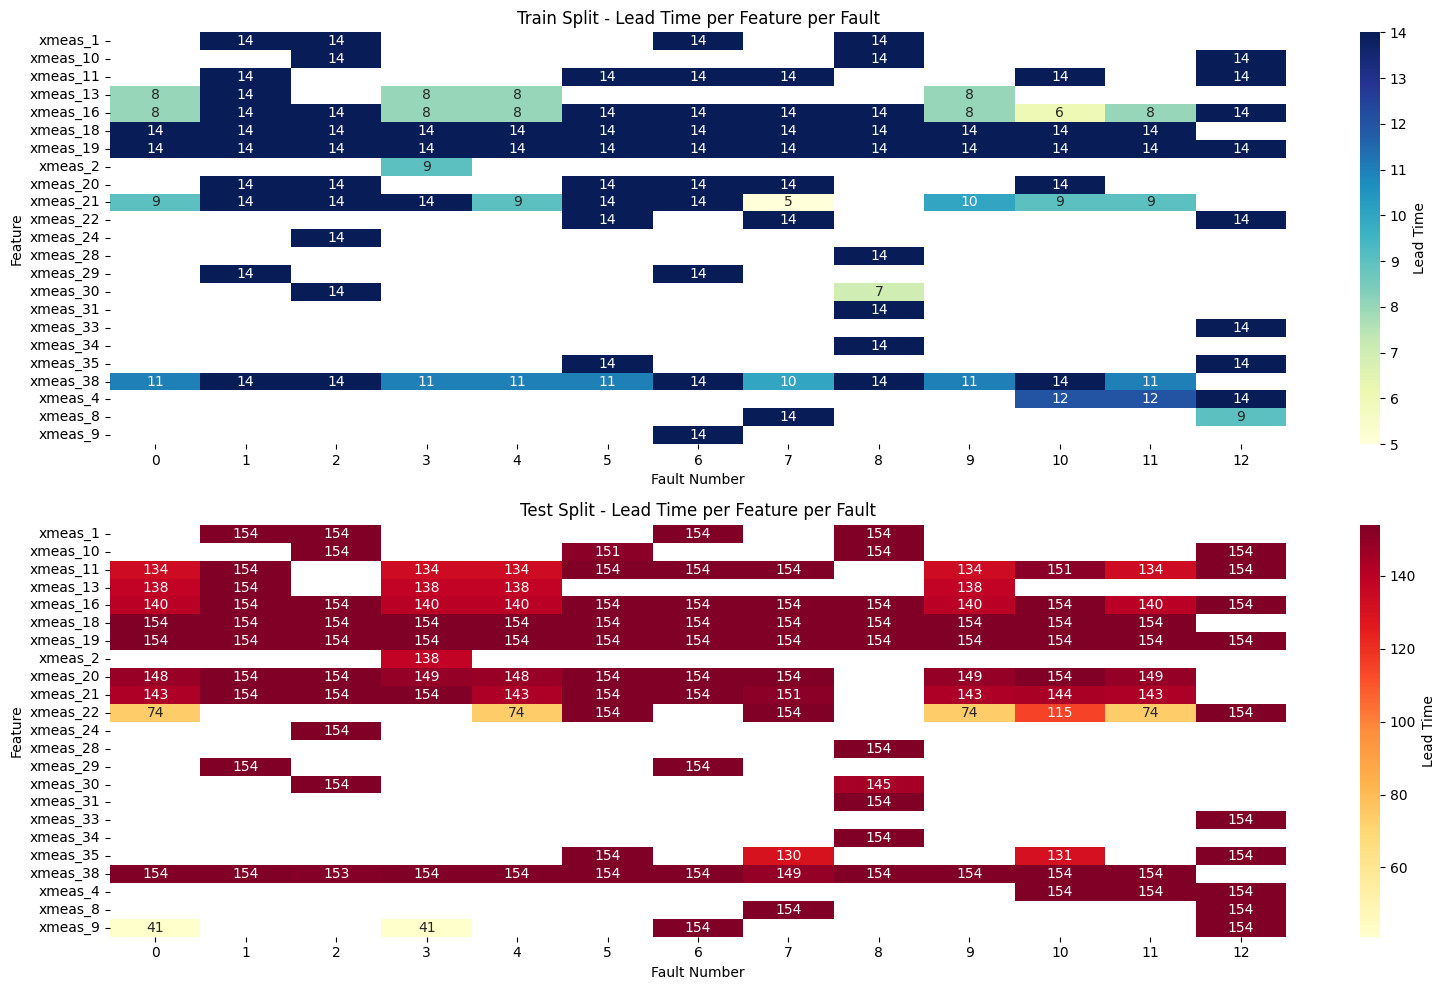

In [18]:
# pivot_train과 pivot_test 각각을 기반으로 seaborn.heatmap() 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Train split heatmap
plt.subplot(2, 1, 1)
sns.heatmap(pivot_train, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Lead Time"})
plt.title("Train Split - Lead Time per Feature per Fault")
plt.xlabel("Fault Number")
plt.ylabel("Feature")

# Test split heatmap
plt.subplot(2, 1, 2)
sns.heatmap(pivot_test, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={"label": "Lead Time"})
plt.title("Test Split - Lead Time per Feature per Fault")
plt.xlabel("Fault Number")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

In [25]:
# split별로 공통적으로 감지된 feature만 필터링

# train과 test 모두에 존재하는 feature 리스트
common_features = pivot_train.index.intersection(pivot_test.index)

# 공통 feature만 필터링한 pivot 테이블 생성
pivot_train_common = pivot_train.loc[common_features]
pivot_test_common = pivot_test.loc[common_features]

print("Train features:", len(pivot_train.index))
print("Test features:", len(pivot_test.index))
print("Common features:", len(common_features))

Train features: 23
Test features: 23
Common features: 23


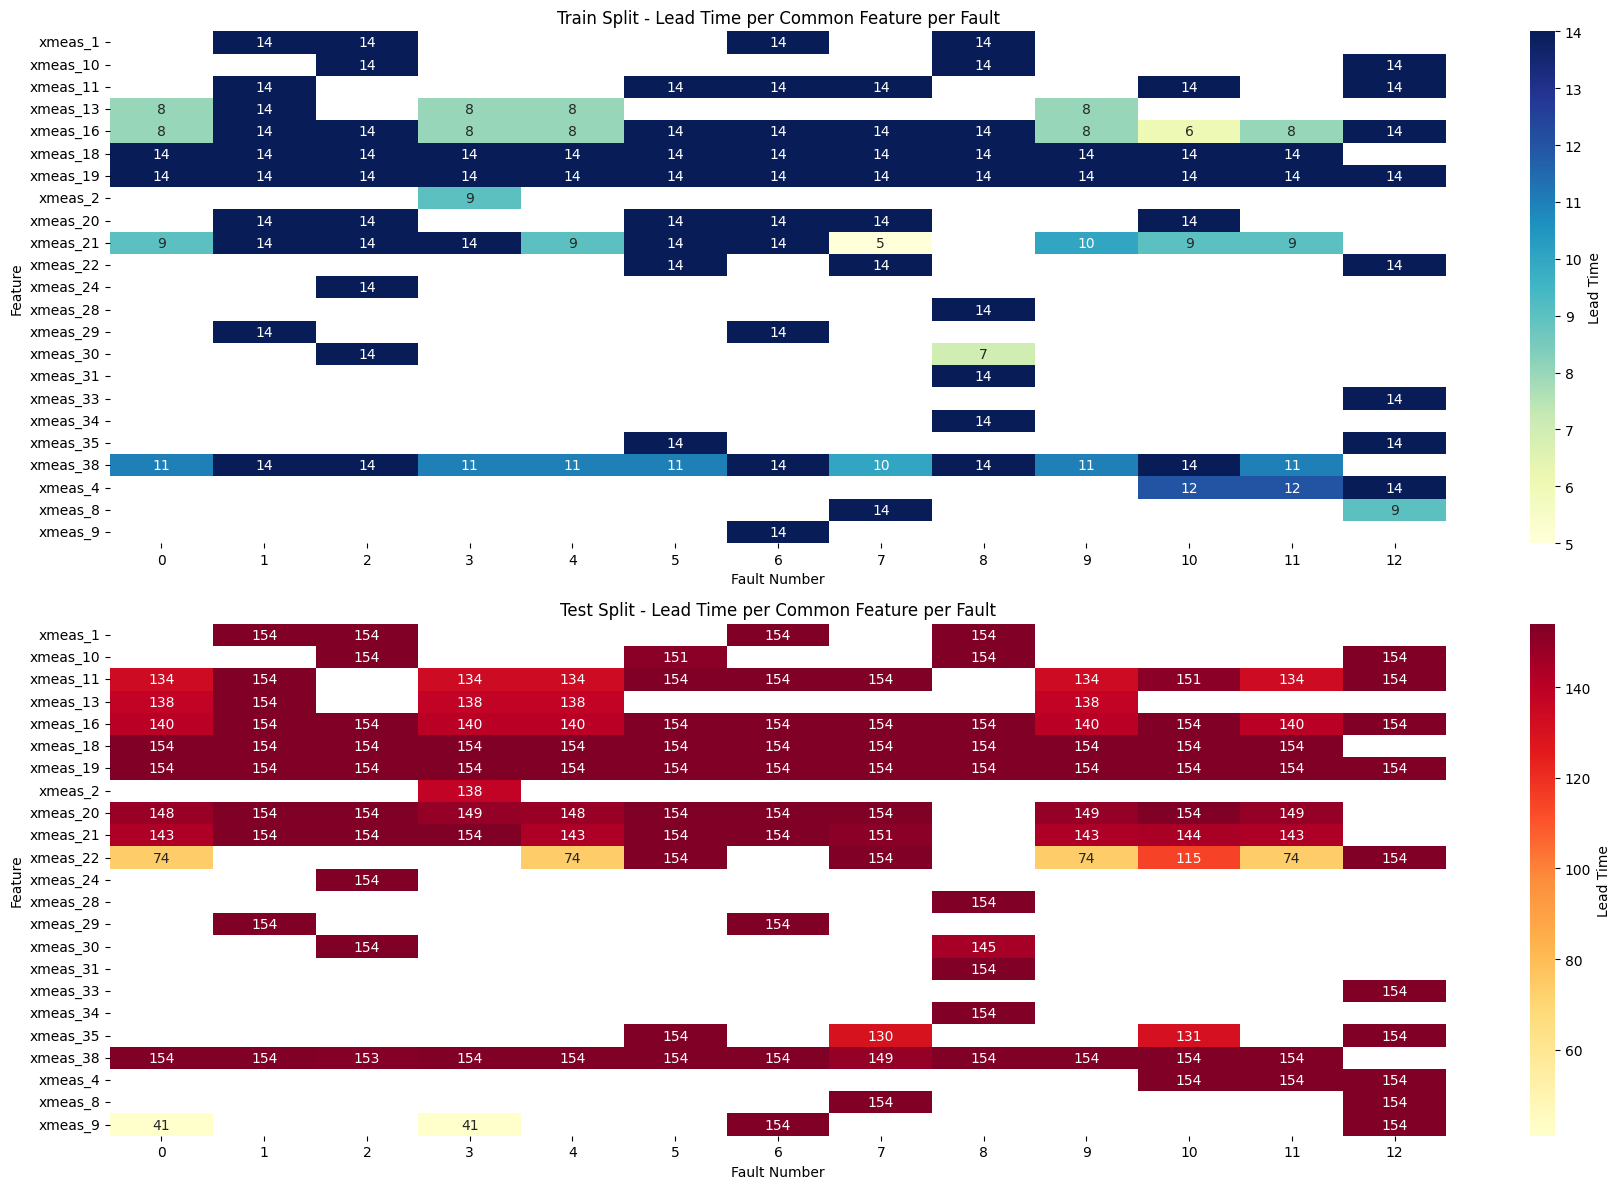

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Train 히트맵
plt.subplot(2, 1, 1)
sns.heatmap(pivot_train_common, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={"label": "Lead Time"})
plt.title("Train Split - Lead Time per Common Feature per Fault")
plt.xlabel("Fault Number")
plt.ylabel("Feature")

# Test 히트맵
plt.subplot(2, 1, 2)
sns.heatmap(pivot_test_common, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={"label": "Lead Time"})
plt.title("Test Split - Lead Time per Common Feature per Fault")
plt.xlabel("Fault Number")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

In [ ]:
# [1] 전체 feature 기반 히트맵과 공통 feature 필터링 히트맵 간 큰 차이가 나타나지 않음
#  → 시각적으로도 거의 동일한 feature들이 주로 경고 신호를 보임
#  → 특히 train/test split 모두에서 동일 feature들이 반복적으로 감지됨

# [2] 고장 감지에 기여하는 핵심 feature들이 split에 상관없이 항상 우선적으로 탐지됨
#  → 예: xmeas_13, xmeas_16, xmeas_18, xmeas_21, xmeas_38 등은 대부분의 fault에서 리드타임이 가장 빠름
#  → 이들 feature는 train/test split이나 filtering 여부와 관계없이 공통적으로 유지됨

# [3] train split에서는 fault별로 다양한 feature들이 비교적 빠르게 반응
#  → 하지만 test split에서는 대부분의 feature가 고정된 최대 리드타임(예: 154)을 갖고 있음
#  → 이는 테스트 데이터에서는 고장 발생 직후 feature 반응성이 강하게 나타나지 않는 경향을 시사함

# [4] 공통 feature 필터링 이후에도 주요 feature는 거의 제거되지 않음
#  → filtering 기준이 완화되어 있거나, 원래부터 주요 feature들이 split 간에 일관되게 감지된 것으로 보임
#  → 따라서 필터링 전후 히트맵에 나타난 결과의 차이가 작게 나타남

# [5] 결론적으로, filtering 유무보다 실제 feature의 고장 반응성이 리드타임 결과에 더 큰 영향을 미침
#  → 즉, 탐지 성능은 split 기반 feature selection보다 feature 자체의 고장 감지 민감도에 더 민감함

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Step 1. CSV 로딩 및 병합
files = {
    'train': [
        'archive/TEP_FaultFree_Training.csv',
        'archive/TEP_Faulty_Training.csv'
    ],
    'test': [
        'archive/TEP_FaultFree_Testing.csv',
        'archive/TEP_Faulty_Testing.csv'
    ]
}

def load_and_concat(file_list):
    return pd.concat([pd.read_csv(f) for f in file_list], axis=0, ignore_index=True)

train = load_and_concat(files['train'])
test = load_and_concat(files['test'])

# Step 2. faultNumber ∈ [0~12]만 사용
valid_faults = list(range(13))  # fault 0~12
train = train[train['faultNumber'].isin(valid_faults)]
test = test[test['faultNumber'].isin(valid_faults)]

# Step 3. 정규화 (fault_0 기준)
# 이상 탐지 시 기준점 정규화를 위함.
sensor_cols = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
fault0 = train[train['faultNumber'] == 0]
scaler = StandardScaler().fit(fault0[sensor_cols])  # fault_0만 기준

train.loc[:, sensor_cols] = scaler.transform(train[sensor_cols])
test.loc[:, sensor_cols] = scaler.transform(test[sensor_cols])

# Step 4. fault별 저장 (지정된 디렉토리 사용)
train_dir = 'data/train/train_fault'
test_dir = 'data/test/test_fault'

def save_by_fault(df, split, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    for f in valid_faults:
        df_f = df[df['faultNumber'] == f]
        out_path = os.path.join(out_dir, f'{split}_fault_{f}.csv')
        df_f[['sample', 'simulationRun', 'faultNumber'] + sensor_cols].to_csv(out_path, index=False)

save_by_fault(train, 'train', train_dir)
save_by_fault(test, 'test', test_dir)

In [ ]:
import numpy as np

def create_soft_label_windows(df, window_size, stride, is_test=False):
    """
    df: 시계열 DataFrame (컬럼: ['sample', 'simulationRun', 'faultNumber', ...])
    window_size: 슬라이딩 윈도우 크기
    stride: 윈도우 간 이동 간격
    is_test: 테스트 데이터 여부 (True면 fault injection step = 160, False면 20)

    반환: (X, Y) 윈도우 및 소프트 라벨
    """
    X_windows = []
    Y_windows = []
    num_fault_classes = 13
    fault_injection_sample = 160 if is_test else 20

    grouped = df.groupby('simulationRun')

    # simulationRun 단위로 그룹을 나누어 처리
    for sim_run, group in grouped:
        fault_id = group['faultNumber'].iloc[0]  # 현재 시뮬레이션의 고장 타입 (정상: 0)
        # 입력 특성만 추출 (메타정보 제거)
        data = group.drop(columns=['sample', 'simulationRun', 'faultNumber']).values
        num_samples = data.shape[0]

        # 슬라이딩 윈도우 생성
        for start in range(0, num_samples - window_size + 1, stride):
            end = start + window_size
            X_window = data[start:end]  # 현재 윈도우 데이터

            # 소프트 라벨 생성
            if fault_id == 0:
                # 정상 시나리오: 항상 [1, 0, ..., 0]
                soft_label = [1.0] + [0.0] * (num_fault_classes - 1)
            else:
                if end <= fault_injection_sample:
                    # 고장 발생 전: 정상으로 간주
                    soft_label = [1.0] + [0.0] * (num_fault_classes - 1)
                elif start >= fault_injection_sample:
                    # 고장 발생 이후 전체 구간: 해당 fault_id에 1.0
                    soft_label = [0.0] * num_fault_classes
                    soft_label[fault_id] = 1.0
                else:
                    # 고장 시점이 윈도우 내에 걸치는 경우: 정상/고장 비율에 따라 소프트 라벨
                    normal_ratio = (fault_injection_sample - start) / window_size
                    fault_ratio = 1.0 - normal_ratio
                    soft_label = [normal_ratio] + [0.0] * (num_fault_classes - 1)
                    soft_label[fault_id] = fault_ratio

            # 결과 저장
            X_windows.append(X_window)
            Y_windows.append(soft_label)

    return np.array(X_windows), np.array(Y_windows)

In [13]:
import glob
import os
import numpy as np

window_size = 50
stride = 10

# --- Train 데이터 처리 ---
train_dir = 'data/train/train_fault'
train_files = glob.glob(os.path.join(train_dir, '*.csv'))
train_save_dir = 'data/train/multiclass_train_data'
os.makedirs(train_save_dir, exist_ok=True)

for file_path in train_files:
    df = pd.read_csv(file_path)
    X_train, Y_train = create_soft_label_windows(df, window_size, stride, is_test=False)
    
    filename = os.path.splitext(os.path.basename(file_path))[0]
    np.save(os.path.join(train_save_dir, f'{filename}_X.npy'), X_train)
    np.save(os.path.join(train_save_dir, f'{filename}_Y.npy'), Y_train)

In [21]:
import glob
import os
import numpy as np

window_size = 50
stride = 10

# --- Test 데이터 처리 ---
test_dir = 'data/test/test_fault'
test_files = glob.glob(os.path.join(test_dir, '*.csv'))
test_save_dir = 'data/test/multiclass_test_data'
os.makedirs(test_save_dir, exist_ok=True)

for file_path in test_files:
    df = pd.read_csv(file_path)
    X_test, Y_test = create_soft_label_windows(df, window_size, stride, is_test=True)
    
    filename = os.path.splitext(os.path.basename(file_path))[0]
    np.save(os.path.join(test_save_dir, f'{filename}_X.npy'), X_test)
    np.save(os.path.join(test_save_dir, f'{filename}_Y.npy'), Y_test)

In [20]:
import numpy as np

X = np.load('data/train/multiclass_train_data/train_fault_5_X.npy')
Y = np.load('data/train/multiclass_train_data/train_fault_5_Y.npy')

print(X.shape, Y.shape, Y[:10])

(23000, 50, 52) (23000, 13) [[0.4 0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]]


In [22]:
import numpy as np

X = np.load('data/test/multiclass_test_data/test_fault_0_X.npy')
Y = np.load('data/test/multiclass_test_data/test_fault_0_Y.npy')

print(X.shape, Y.shape, Y[:10])

(46000, 50, 52) (46000, 13) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
import os
import glob
import numpy as np

def load_and_convert_labels(label_dir, label_suffix='_Y.npy'):
    """
    주어진 디렉터리 내 모든 소프트 라벨 Y 파일을 로드하고
    소프트 라벨 → 정수 라벨 변환 후 딕셔너리로 반환

    label_dir: Y 파일 경로
    label_suffix: Y 파일 접미사 (예: '_Y.npy')

    반환: {fault_name: integer_label_array}
    """
    pattern = os.path.join(label_dir, f'*{label_suffix}')
    file_paths = glob.glob(pattern)

    labels_dict = {}
    for path in file_paths:
        filename = os.path.basename(path)
        fault_name = filename.replace(label_suffix, '')
        
        # 소프트 라벨 로드
        soft_labels = np.load(path)  # shape: (num_samples, num_classes)
        
        # argmax로 가장 높은 확률 인덱스를 정수 라벨로 변환
        int_labels = np.argmax(soft_labels, axis=1)
        
        labels_dict[fault_name] = int_labels

    return labels_dict

In [24]:
# 데이터 로드
train_label_dir = 'data/train/multiclass_train_data'

train_int_labels = load_and_convert_labels(train_label_dir)
print(f"Train integer labels keys: {list(train_int_labels.keys())}")

for fault_name, int_labels in train_int_labels.items():
    save_path = os.path.join(train_label_dir, fault_name + '_intY.npy')
    np.save(save_path, int_labels)

Train integer labels keys: ['train_fault_8', 'train_fault_9', 'train_fault_10', 'train_fault_7', 'train_fault_5', 'train_fault_12', 'train_fault_1', 'train_fault_3', 'train_fault_4', 'train_fault_11', 'train_fault_6', 'train_fault_2', 'train_fault_0']


In [25]:
# 데이터 로드
test_label_dir = 'data/test/multiclass_test_data'

test_int_labels = load_and_convert_labels(test_label_dir)
print(f"Test integer labels keys: {list(test_int_labels.keys())}")

for fault_name, int_labels in test_int_labels.items():
    save_path = os.path.join(test_label_dir, fault_name + '_intY.npy')
    np.save(save_path, int_labels)

Test integer labels keys: ['test_fault_8', 'test_fault_9', 'test_fault_3', 'test_fault_1', 'test_fault_5', 'test_fault_12', 'test_fault_10', 'test_fault_7', 'test_fault_0', 'test_fault_2', 'test_fault_11', 'test_fault_6', 'test_fault_4']


In [27]:
# 저장한 정수 라벨 불러오기 및 확인
loaded_fault_ids = np.load('data/train/multiclass_train_data/train_fault_5_intY.npy')

print("정수 라벨 shape:", loaded_fault_ids.shape)
print("처음 10개 라벨:", loaded_fault_ids[:10])
print("라벨 종류:", np.unique(loaded_fault_ids))

정수 라벨 shape: (23000,)
처음 10개 라벨: [5 5 5 5 5 5 5 5 5 5]
라벨 종류: [5]


In [29]:
# 저장한 정수 라벨 불러오기 및 확인
loaded_fault_ids = np.load('data/test/multiclass_test_data/test_fault_8_intY.npy')

print("정수 라벨 shape:", loaded_fault_ids.shape)
print("처음 10개 라벨:", loaded_fault_ids[:10])
print("라벨 종류:", np.unique(loaded_fault_ids))

정수 라벨 shape: (46000,)
처음 10개 라벨: [0 0 0 0 0 0 0 0 0 0]
라벨 종류: [0 8]


In [30]:
import os
import glob
import numpy as np

def merge_npy_files(input_dir, output_dir, prefix):
    os.makedirs(output_dir, exist_ok=True)

    # 각 타입별 파일 리스트 가져오기
    x_files = sorted(glob.glob(os.path.join(input_dir, '*_X.npy')))
    y_files = sorted(glob.glob(os.path.join(input_dir, '*_Y.npy')))
    inty_files = sorted(glob.glob(os.path.join(input_dir, '*_intY.npy')))

    # 데이터 병합
    X_list, Y_list, intY_list = [], [], []

    for xf, yf, intyf in zip(x_files, y_files, inty_files):
        X_list.append(np.load(xf))
        Y_list.append(np.load(yf))
        intY_list.append(np.load(intyf))

    X_merged = np.concatenate(X_list, axis=0)
    Y_merged = np.concatenate(Y_list, axis=0)
    intY_merged = np.concatenate(intY_list, axis=0)

    # 저장
    np.save(os.path.join(output_dir, f'{prefix}_X.npy'), X_merged)
    np.save(os.path.join(output_dir, f'{prefix}_Y.npy'), Y_merged)
    np.save(os.path.join(output_dir, f'{prefix}_intY.npy'), intY_merged)

    print(f'Merged {len(x_files)} files from {input_dir} into {output_dir}')
    print(f'Saved shapes: X={X_merged.shape}, Y={Y_merged.shape}, intY={intY_merged.shape}')

if __name__ == "__main__":
    # Train 데이터 병합
    train_input_dir = 'data/train/multiclass_train_data'
    train_output_dir = 'data/train/merged_train_data'
    merge_npy_files(train_input_dir, train_output_dir, 'train')

    # Test 데이터 병합
    test_input_dir = 'data/test/multiclass_test_data'
    test_output_dir = 'data/test/merged_test_data'
    merge_npy_files(test_input_dir, test_output_dir, 'test')

Merged 13 files from data/train/multiclass_train_data into data/train/merged_train_data
Saved shapes: X=(299000, 50, 52), Y=(299000, 13), intY=(299000,)
Merged 13 files from data/test/multiclass_test_data into data/test/merged_test_data
Saved shapes: X=(598000, 50, 52), Y=(598000, 13), intY=(598000,)


In [32]:
import numpy as np

# 병합된 train/test X 파일 로드
X_train = np.load("data/train/merged_train_data/train_X.npy")  # (299000, 50, 52)
X_test = np.load("data/test/merged_test_data/test_X.npy")     # (598000, 50, 52)

# 타임스텝 기준 통계 계산 (axis=0: 윈도우, axis=1: 타임스텝)
# 결과: (50, 52)
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

test_mean = np.mean(X_test, axis=0)
test_std = np.std(X_test, axis=0)

print(train_mean.shape, train_std.shape) 
print(test_mean.shape, test_std.shape)

(50, 52) (50, 52)
(50, 52) (50, 52)


/var/folders/_f/blcp938905ddt8s7snyhdsv00000gn/T/ipykernel_98480/4061179239.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


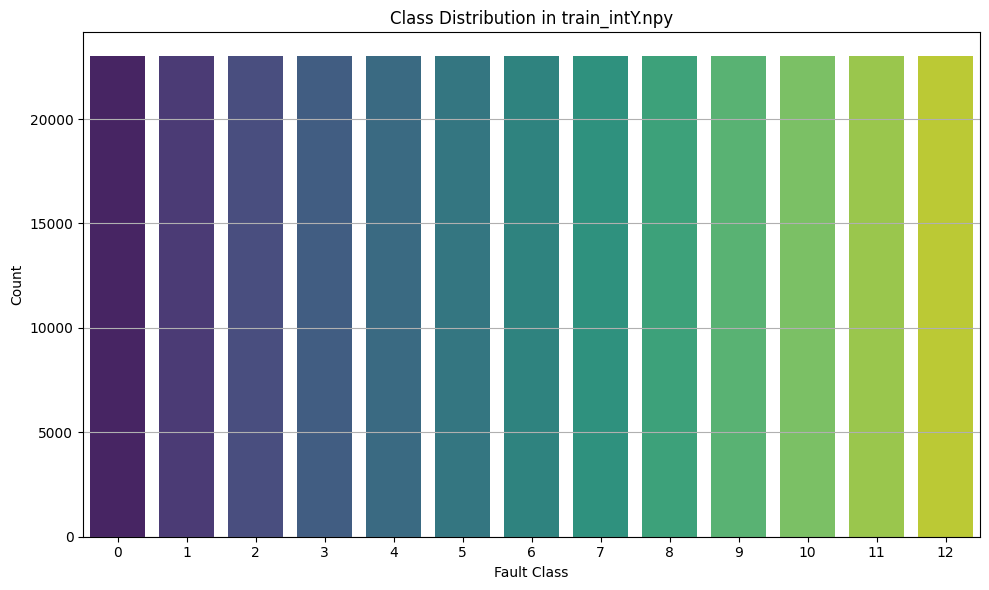

[(np.int64(0), np.int64(23000)),
 (np.int64(1), np.int64(23000)),
 (np.int64(2), np.int64(23000)),
 (np.int64(3), np.int64(23000)),
 (np.int64(4), np.int64(23000)),
 (np.int64(5), np.int64(23000)),
 (np.int64(6), np.int64(23000)),
 (np.int64(7), np.int64(23000)),
 (np.int64(8), np.int64(23000)),
 (np.int64(9), np.int64(23000)),
 (np.int64(10), np.int64(23000)),
 (np.int64(11), np.int64(23000)),
 (np.int64(12), np.int64(23000))]

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load integer labels
train_intY = np.load("data/train/merged_train_data/train_intY.npy")

# Count class distribution
unique, counts = np.unique(train_intY, return_counts=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel("Fault Class")
plt.ylabel("Count")
plt.title("Class Distribution in train_intY.npy")
plt.xticks(ticks=range(len(unique)))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Output statistics
list(zip(unique, counts))

/var/folders/_f/blcp938905ddt8s7snyhdsv00000gn/T/ipykernel_98480/264112989.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


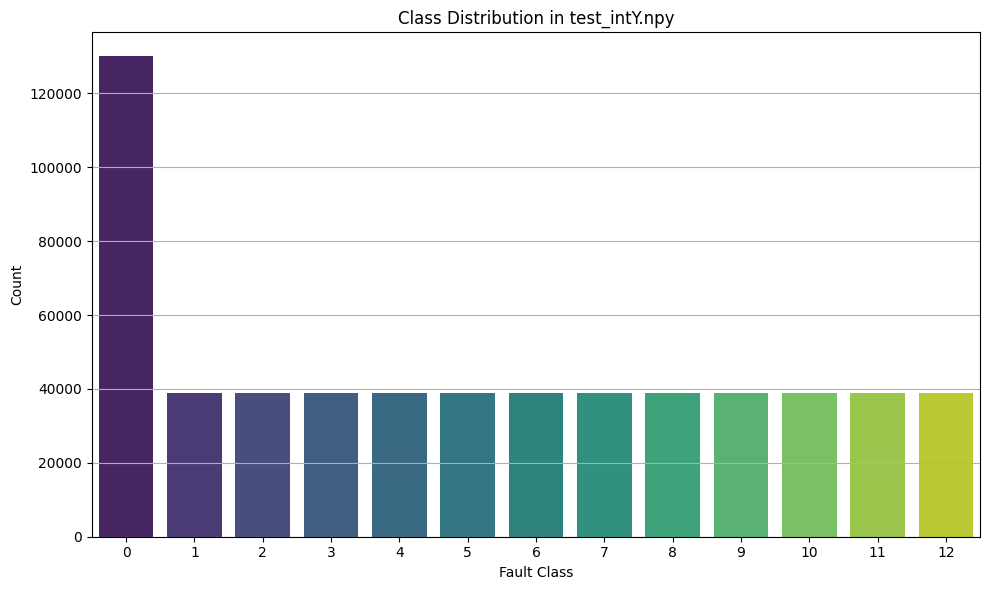

[(np.int64(0), np.int64(130000)),
 (np.int64(1), np.int64(39000)),
 (np.int64(2), np.int64(39000)),
 (np.int64(3), np.int64(39000)),
 (np.int64(4), np.int64(39000)),
 (np.int64(5), np.int64(39000)),
 (np.int64(6), np.int64(39000)),
 (np.int64(7), np.int64(39000)),
 (np.int64(8), np.int64(39000)),
 (np.int64(9), np.int64(39000)),
 (np.int64(10), np.int64(39000)),
 (np.int64(11), np.int64(39000)),
 (np.int64(12), np.int64(39000))]

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load integer labels
test_intY = np.load("data/test/merged_test_data/test_intY.npy")

# Count class distribution
unique, counts = np.unique(test_intY, return_counts=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel("Fault Class")
plt.ylabel("Count")
plt.title("Class Distribution in test_intY.npy")
plt.xticks(ticks=range(len(unique)))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Output statistics
list(zip(unique, counts))

In [ ]:
# ==========================================
# 정적 라벨링 (Static Labeling)
# ==========================================
# 정의:
#   - 각 윈도우(window)에 대해 단일 정수형 라벨(fault_id)을 부여
#     정상: 0
#     결함: fault number (1~12)
#
# 장점:
#   1. 구현 단순성:
#      - 각 샘플에 대해 단일 라벨만 필요하므로 코드, 모델 설계, 디버깅이 간단함
#   2. 표준 분류 손실함수 호환성:
#      - CrossEntropyLoss 등에서 직접 사용 가능
#   3. 효율적 학습:
#      - 모델이 예측해야 할 라벨이 명확 → 빠른 수렴
#
# 적합한 경우:
#   - fault injection 이후의 고장 구간만을 사용하는 경우
#     (e.g., start >= fault_injection_step + margin)
#   - 경계 구간 제거 후 순수한 고장/정상 시퀀스를 다룰 때
#
# 단점 (부적합한 경우):
#   1. 고장 주입 경계 구간 문제:
#      - fault 발생 시점(예: step 160)을 **걸쳐 있는 윈도우**에 대해서도
#        무조건 고장 라벨을 할당하면, 일부 정상 데이터가 포함된 샘플에 잘못된 라벨이 부여됨
#   2. soft transition 무시:
#      - 실제 고장은 정상 → 이상 징후 → 결함 상태로 점진적으로 이행됨
#        정적 라벨링은 이러한 동적 변화를 반영하지 못함
#   3. label noise 유발 가능성:
#      - 경계 구간에 존재하는 윈도우의 실제 label과 주어진 label 간 mismatch 가능성


# ==========================================
# 소프트 라벨링 (Soft Labeling)
# ==========================================
# 정의:
#   - 윈도우 내의 데이터가 정상/고장 상태를 **혼합**하는 경우,
#     라벨 벡터에 각 상태의 비율을 반영하여 soft-label 할당
#     예: fault 5, window [140:190], fault step = 160 → [0.4, 0.0, 0.0, 0.0, 0.0, 0.6, ..., 0.0]
#
# 장점:
#   1. 경계 구간의 표현력 향상:
#      - 정상→고장으로 이행하는 윈도우에서 정상/고장 상태를 비율로 표현 가능
#   2. label noise 감소:
#      - 완전히 고장이 아님에도 고장으로 라벨링되는 오류를 방지
#   3. 고장 진행 과정 학습 가능:
#      - 모델이 고장 징후(fault onset)를 조기에 인식하도록 학습할 수 있음
#
# 적합한 경우:
#   - 전체 시계열을 대상으로 슬라이딩 윈도우를 구성할 때
#   - 고장 주입 전후 과도기(transient phase) 포함하여 모델이 조기 탐지(early detection)를 학습해야 할 때
#
# 단점:
#   1. 복잡성 증가:
#      - 라벨이 one-hot이 아니므로 CrossEntropyLoss를 사용할 수 없고 MSE 등 soft-label-friendly한 손실함수 필요
#   2. 분류 성능 평가 지표 적용 어려움:
#      - 정확도, 정밀도, F1 등 discrete class 기반 metric 사용 시 thresholding 등 별도 처리 필요
